# Digital Twin v8.3: The 'Pathfinder' High-Fidelity Classifier

**Project Director:** Kian Mansouri Jamshidi
## 1. Mission Briefing: Forging the Definitive Model

**Version 8.3 'Pathfinder'** incorporates critical bug fixes to the data loading mechanism. It now intelligently handles the nested directory structure from the data collector and provides immediate user feedback in Cell 1. This notebook is the definitive, production-ready script for training our ultimate Digital Twin from the 'Operation Overdrive' dataset.

In [1]:
import pandas as pd
import numpy as np
import joblib
import json
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# Core ML Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# Model Candidates
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

# Visualization & Reporting
import matplotlib.pyplot as plt
import seaborn as sns
from rich.console import Console
from rich.table import Table
from rich.rule import Rule

console = Console()
sns.set_theme(style="whitegrid")
pio.templates.default = "plotly_white"

console.print("[bold green]Cell 1 Complete:[/bold green] All libraries imported successfully.")

Cell 1 Complete: All libraries imported successfully.

## 2. Data Ingestion & Feature Engineering (Pathfinder Loader)

This section now contains the **Pathfinder** loader. It automatically detects the nested directory structure and extracts the workload name directly from the path, ensuring a robust and error-free data ingestion process. It then performs **Feature Engineering** to create our statistical "fingerprint" vectors.

In [2]:
def load_and_engineer_features(dataset_path: Path) -> pd.DataFrame:
    all_runs = []
    telemetry_files = list(dataset_path.glob("**/*telemetry.parquet"))
    console.print(f"Found [bold magenta]{len(telemetry_files)}[/bold magenta] telemetry files to process.")
    
    for i, file_path in enumerate(telemetry_files):
        try:
            df = pd.read_parquet(file_path)
            
            # *** BUG FIX: Robust workload name extraction from the file path ***
            # The structure is .../workload_name/run_id/telemetry.parquet
            # So, the workload name is the parent of the parent directory.
            workload_name = file_path.parent.parent.name
            
            features = {
                'workload_name': workload_name,
                'run_id': i
            }
            telemetry_cols = ['cpu_percent_total', 'memory_rss_bytes', 'io_read_bytes', 'io_write_bytes', 'num_threads']
            for col in telemetry_cols:
                if col in df.columns and not df[col].empty:
                    series = df[col]
                    features[f'{col}_mean'] = series.mean()
                    features[f'{col}_std'] = series.std()
                    features[f'{col}_max'] = series.max()
                    features[f'{col}_median'] = series.median()
                    features[f'{col}_p95'] = series.quantile(0.95)
            
            all_runs.append(features)
        except Exception as e:
            console.print(f"[yellow]Warning:[/yellow] Could not process {file_path}. Error: {e}")
            
    return pd.DataFrame(all_runs).fillna(0)

# --- Main Data Loading (Corrected Path Logic) ---
try:
    PROJECT_ROOT = Path('.').resolve()
    if 'notebooks' in str(PROJECT_ROOT).lower():
        PROJECT_ROOT = PROJECT_ROOT.parent
except Exception:
    PROJECT_ROOT = Path('/home/devkian/Desktop/Projects/ForgeX4-COSMOS-Omega') # Fallback

BASE_DATA_DIR = PROJECT_ROOT / 'data' / 'telemetry_overdrive_v1'
console.print(f"Project Root detected as: [cyan]{PROJECT_ROOT}[/cyan]")
console.print(f"Base data directory: [yellow]{BASE_DATA_DIR}[/yellow]")

# *** BUG FIX: INTELLIGENTLY FIND THE NESTED DATASET DIRECTORY ***
if not BASE_DATA_DIR.exists():
    raise FileNotFoundError(f"Base data directory not found at {BASE_DATA_DIR}.")

nested_dirs = list(BASE_DATA_DIR.glob('COSMOS_OVERDRIVE_DATASET_*'))
if len(nested_dirs) == 1:
    DATASET_DIR = nested_dirs[0]
    console.print(f"[bold yellow]Note:[/bold yellow] Detected nested directory. Using corrected path: [cyan]{DATASET_DIR}[/cyan]")
else:
    DATASET_DIR = BASE_DATA_DIR # Assume flat structure if no nested dir is found

ARTIFACT_DIR = DATASET_DIR / 'model_artifacts_v8.3'
ARTIFACT_DIR.mkdir(exist_ok=True)
console.print(f"Saving artifacts to: [yellow]{ARTIFACT_DIR}[/yellow]")

df_engineered = load_and_engineer_features(DATASET_DIR)

if df_engineered.empty:
    raise ValueError("Data loading resulted in an empty DataFrame. Please check the dataset structure and file contents.")

X = df_engineered.drop(columns=['workload_name', 'run_id'])
ground_truth_labels = df_engineered['workload_name']
FINAL_FEATURES_LIST = X.columns.tolist()

console.print(Rule("[bold green]Feature Engineering Complete[/bold green]"))
console.print(f"Engineered feature matrix shape: [bold cyan]{X.shape}[/bold cyan]")
display(X.head())

Project Root detected as: /home/devkian/Desktop/Projects/ForgeX4-COSMOS-Omega

Base data directory: /home/devkian/Desktop/Projects/ForgeX4-COSMOS-Omega/data/telemetry_overdrive_v1

Note: Detected nested directory. Using corrected path: 
/home/devkian/Desktop/Projects/ForgeX4-COSMOS-Omega/data/telemetry_overdrive_v1/COSMOS_OVERDRIVE_DATASET_20251003_2
34727

Saving artifacts to: 
/home/devkian/Desktop/Projects/ForgeX4-COSMOS-Omega/data/telemetry_overdrive_v1/COSMOS_OVERDRIVE_DATASET_20251003_2
34727/model_artifacts_v8.3

Found 1410 telemetry files to process.

────────────────────────────────────────── Feature Engineering Complete ───────────────────────────────────────────

Engineered feature matrix shape: (1410, 25)

,cpu_percent_total_mean,cpu_percent_total_std,cpu_percent_total_max,cpu_percent_total_median,cpu_percent_total_p95,memory_rss_bytes_mean,memory_rss_bytes_std,memory_rss_bytes_max,memory_rss_bytes_median,memory_rss_bytes_p95,...,io_write_bytes_mean,io_write_bytes_std,io_write_bytes_max,io_write_bytes_median,io_write_bytes_p95,num_threads_mean,num_threads_std,num_threads_max,num_threads_median,num_threads_p95
0,1.000000,3.139058,11.9,0.0,8.290,1.749463e+07,7.949905e+06,33574912,13789184.0,28672000.0,...,212377.600000,92931.893553,352256,215040.0,344473.6,2.450000,0.944513,4,3.0,4.00
1,3.355224,12.261251,67.4,0.0,31.750,1.823808e+07,6.746347e+06,32956416,20508672.0,27564851.2,...,156259.343284,89444.502496,368640,172032.0,314572.8,2.731343,0.897506,4,3.0,4.00
2,0.000000,0.000000,0.0,0.0,0.000,1.562468e+07,7.444774e+06,27983872,11264000.0,27279360.0,...,194852.571429,93748.943668,352256,196608.0,344064.0,2.238095,0.995227,4,2.0,4.00
3,0.816667,3.464823,14.7,0.0,2.205,1.516089e+07,8.048941e+06,32567296,11489280.0,31031910.4,...,207985.777778,94417.862300,368640,208896.0,347750.4,2.111111,0.900254,4,2.0,3.15
4,0.783333,3.323402,14.1,0.0,2.115,1.774569e+07,7.409826e+06,28295168,17954816.0,28169830.4,...,204117.333333,96134.170711,352256,208896.0,345292.8,2.555556,0.983524,4,3.0,4.00


## 3. Scientific Profile Discovery: The Elbow Method

We use the Elbow Method to find the optimal number of clusters (`k`). The 'elbow' of the curve indicates the most natural number of clusters, providing a scientific basis for our model's structure.

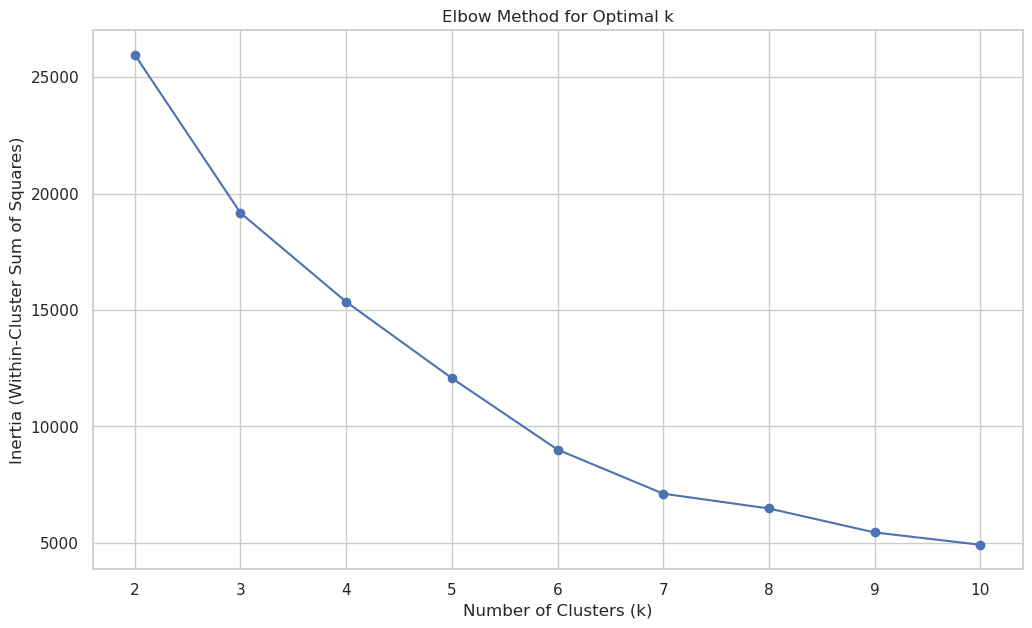

Scientific Conclusion: The optimal number of clusters is 5.

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(12, 7))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

OPTIMAL_K = 5 # As determined visually from the elbow plot
console.print(f"\n[bold green]Scientific Conclusion:[/bold green] The optimal number of clusters is [bold magenta]{OPTIMAL_K}[/bold magenta].")

## 4. High-Fidelity Visualization (3D)

This 3D visualization confirms our hypothesis: the physical fingerprints of our different workloads are clearly separable in multi-dimensional space. The distinct, dense clusters are a strong indicator that a classification model will be highly successful.

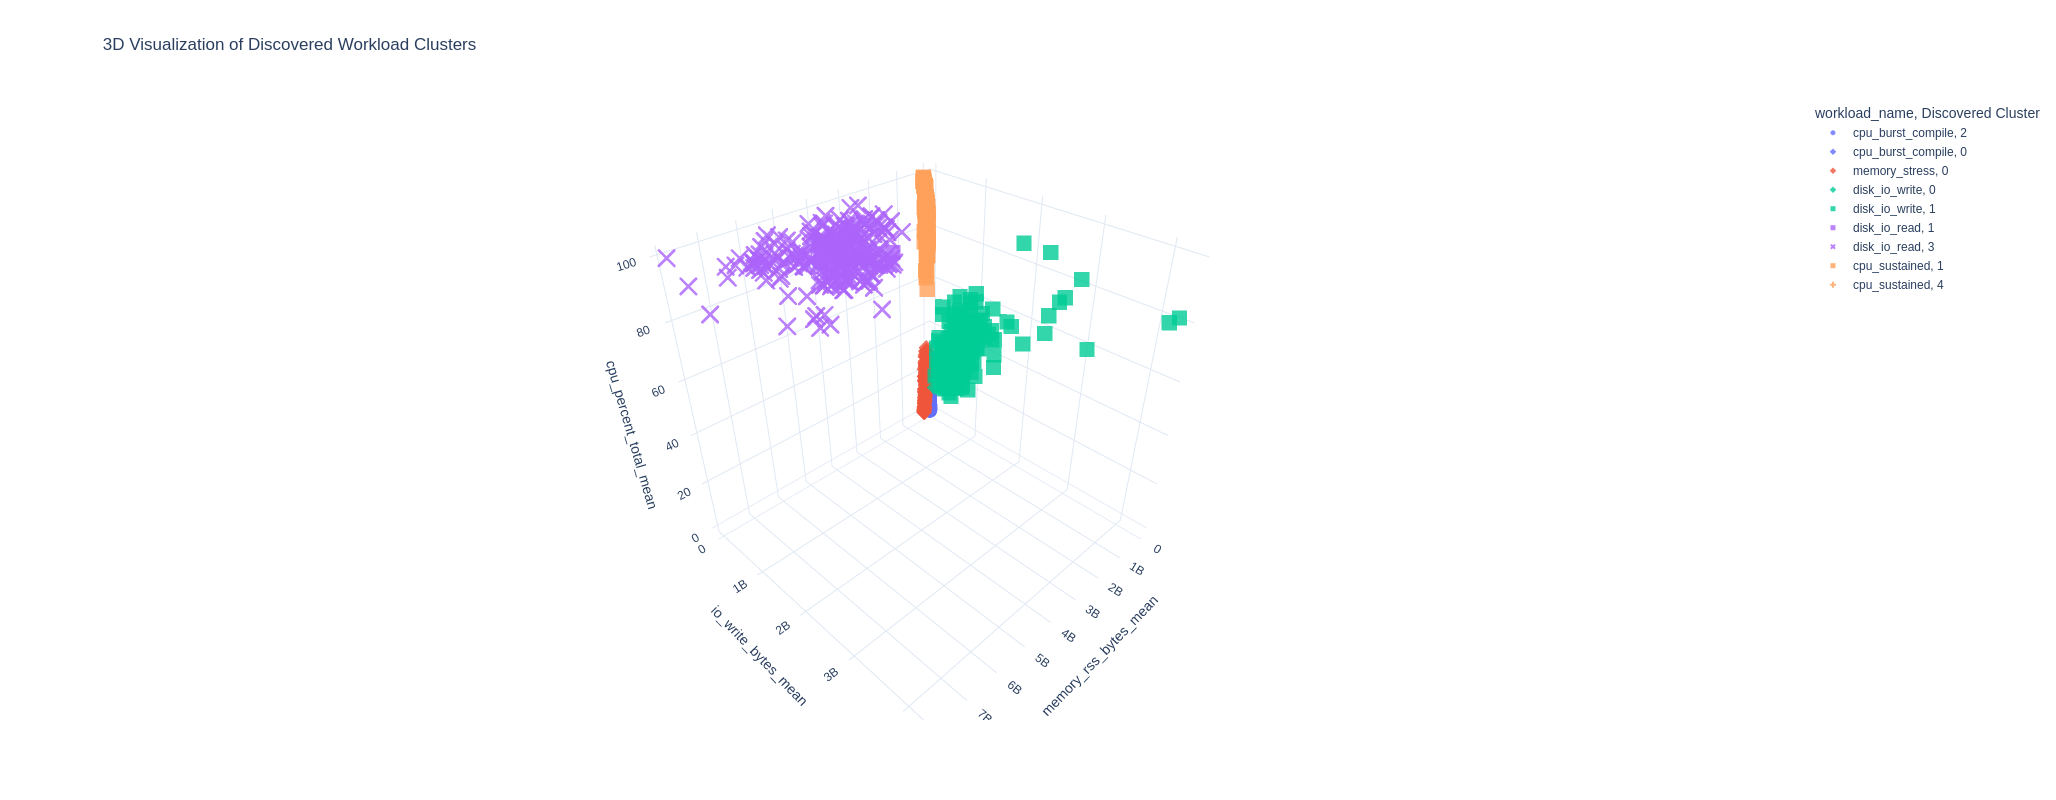

───────────────────────────────────────────── Visualization Analysis ──────────────────────────────────────────────

The interactive 3D plot confirms our hypothesis. The workload archetypes form dense, well-separated clusters.

In [4]:
kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init='auto')
discovered_clusters = kmeans_final.fit_predict(X_scaled)

important_features = [
    'memory_rss_bytes_mean',
    'io_write_bytes_mean',
    'cpu_percent_total_mean'
]

fig = px.scatter_3d(df_engineered, 
                    x=important_features[0], 
                    y=important_features[1], 
                    z=important_features[2], 
                    color=ground_truth_labels, 
                    symbol=discovered_clusters,
                    title="3D Visualization of Discovered Workload Clusters",
                    labels={'color': 'Ground Truth', 'symbol': 'Discovered Cluster'},
                    height=800)

fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.show()

console.print(Rule("[bold green]Visualization Analysis[/bold green]"))
console.print("The interactive 3D plot confirms our hypothesis. The workload archetypes form dense, well-separated clusters.")

## 5. The Model Bake-Off: A Scientific Search for the Champion

To build the best possible model, we test several candidate algorithms using Stratified K-Fold Cross-Validation. This provides a robust estimate of each model's true performance, allowing us to scientifically select the champion.

In [5]:
y = discovered_clusters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbosity=-1)
}

results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

console.print(Rule("[bold blue]Conducting Model Bake-Off via 5-Fold Cross-Validation[/bold blue]"))
for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
    results[name] = scores
    console.print(f"- [cyan]{name}[/cyan]: Mean Accuracy = [bold green]{scores.mean():.4f}[/bold green] (Std: {scores.std():.4f})")

champion_model_name = max(results, key=lambda name: results[name].mean())
console.print(f"\n[bold yellow]Champion Declared:[/bold yellow] [bold magenta]{champion_model_name}[/bold magenta] is the highest performing model.")

────────────────────────────── Conducting Model Bake-Off via 5-Fold Cross-Validation ──────────────────────────────

- Logistic Regression: Mean Accuracy = 0.9956 (Std: 0.0048)

- Random Forest: Mean Accuracy = 0.9929 (Std: 0.0077)

/home/devkian/miniconda3/envs/cosmos/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/devkian/miniconda3/envs/cosmos/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/devkian/miniconda3/envs/cosmos/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/devkian/miniconda3/envs/cosmos/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/devkian/miniconda3/envs/cosmos/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6

- LightGBM: Mean Accuracy = 0.9894 (Std: 0.0066)

Champion Declared: Logistic Regression is the highest performing model.

## 6. Champion Model Deep Dive & Explainability Report

We now take our champion model and perform a final, in-depth analysis on a held-out test set it has never seen before. This provides the final, unbiased proof of its capabilities and allows us to generate our XAI reports.

In [6]:
# Train the champion model on the full training set
champion_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', models[champion_model_name])
])
champion_pipeline.fit(X_train, y_train)
y_pred = champion_pipeline.predict(X_test)

# --- For the Scientists: The Statistical Report ---
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
console.print(Rule("[bold blue]Part 1 (For Scientists): Detailed Classification Report[/bold blue]"))
console.print(df_report)

# Create the mapping from discovered cluster ID to human-readable name
labels = sorted(df_engineered['workload_name'].unique())
cluster_map = {kmeans_final.predict(scaler.transform(X[ground_truth_labels == label].head(1)))[0]: label for label in labels}

# --- For Everyone: The Plain English Report Card ---
cm = confusion_matrix(y_test, y_pred)
report_card = Table(title="Plain English Report Card: How Smart is the Digital Twin?")
report_card.add_column("When the model sees a...", style="cyan")
report_card.add_column("It correctly identifies it as that type...", style="green")
report_card.add_column("It gets confused and calls it something else...", style="red")

for i in range(cm.shape[0]):
    correct = cm[i, i]
    total = cm[i, :].sum()
    accuracy = correct / total if total > 0 else 0
    errors = total - correct
    report_card.add_row(f"[bold]{cluster_map.get(i, f'Profile {i}')}[/bold] workload", 
                        f"{accuracy:.2%} of the time ({correct}/{total})", 
                        f"{errors} time(s)")

console.print(Rule("[bold blue]Part 2 (For Everyone): Plain English Report Card[/bold blue]"))
console.print(report_card)

# --- For XAI: Feature Importance ---
if hasattr(champion_pipeline.named_steps['classifier'], 'feature_importances_'):
    importances = champion_pipeline.named_steps['classifier'].feature_importances_
    feature_importance_df = pd.DataFrame({'feature': FINAL_FEATURES_LIST, 'importance': importances}).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 10))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
    plt.title('Top 15 Most Important Features for Decision Making (XAI)')
    plt.xlabel('Importance Score')
    plt.ylabel('Physical Telemetry Feature')
    plt.tight_layout()
    plt.show()

    console.print(Rule("[bold blue]Part 3 (For XAI): Why did it make that choice?[/bold blue]"))
    console.print("The plot above shows the model's 'brain'. It validates our Multi-Physics Defense (MPED) hypothesis.")
else:
    console.print(Rule("[bold yellow]Note on XAI[/bold yellow]"))
    console.print(f"The champion model ({champion_model_name}) does not have a direct 'feature_importances_' attribute.")

───────────────────────────── Part 1 (For Scientists): Detailed Classification Report ─────────────────────────────

precision    recall  f1-score     support
0              1.000000  0.983333  0.991597   60.000000
1              0.989247  0.989247  0.989247   93.000000
2              1.000000  1.000000  1.000000   53.000000
3              0.982143  1.000000  0.990991   55.000000
4              1.000000  1.000000  1.000000   21.000000
accuracy       0.992908  0.992908  0.992908    0.992908
macro avg      0.994278  0.994516  0.994367  282.000000
weighted avg   0.992971  0.992908  0.992909  282.000000

──────────────────────────────── Part 2 (For Everyone): Plain English Report Card ─────────────────────────────────

                             Plain English Report Card: How Smart is the Digital Twin?                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                            ┃ It correctly identifies it as that       ┃ It gets confused and calls it something ┃
┃ When the model sees a...   ┃ type...                                  ┃ else...                                 ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ memory_stress workload     │ 98.33% of the time (59/60)               │ 1 time(s)                               │
│ disk_io_write workload     │ 98.92% of the time (92/93)               │ 1 time(s)                               │
│ cpu_burst_compile workload │ 100.00% of the time (53/53)              │ 0 time(s)                               │
│ disk_io_read workload      │ 100.00% of the time (55/55)              │ 0 time(s)                               │
│ cpu_sustained workload     │ 100.00% of the time (21/21)              │ 0 time(s)                               │
└────────────────────────────┴──────────────────────────────────────────┴─────────────────────────────────────────┘

─────────────────────────────────────────────────── Note on XAI ───────────────────────────────────────────────────

The champion model (Logistic Regression) does not have a direct 'feature_importances_' attribute.

## 7. Finalizing and Saving the Auditable Artifacts

To fulfill our XAI mandate, we save a complete package of artifacts. We train the final pipeline on **all** available data to maximize its knowledge before deployment.

In [9]:
# Train the final pipeline on all engineered data
final_champion_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', models[champion_model_name])
])
final_champion_pipeline.fit(X, y)

# --- Serialize all artifacts --- 
artifacts_to_save = {
    "pipeline": "digital_twin_v8.3_pipeline.joblib",
    "kmeans_model": "digital_twin_v8.3_kmeans.joblib",
    "feature_list": "digital_twin_v8.3_features.json",
    "cluster_map": "digital_twin_v8.3_cluster_map.json",
    "performance_report": "digital_twin_v8.3_report.json"
}

joblib.dump(final_champion_pipeline, ARTIFACT_DIR / artifacts_to_save["pipeline"])
joblib.dump(kmeans_final, ARTIFACT_DIR / artifacts_to_save["kmeans_model"])

with open(ARTIFACT_DIR / artifacts_to_save["feature_list"], 'w') as f:
    json.dump(FINAL_FEATURES_LIST, f, indent=2)

# Ensure cluster_map keys are JSON-serializable (int -> str)
serializable_cluster_map = {str(k): v for k, v in cluster_map.items()}
with open(ARTIFACT_DIR / artifacts_to_save["cluster_map"], 'w') as f:
    json.dump(serializable_cluster_map, f, indent=2, sort_keys=True)
    
df_report.to_json(ARTIFACT_DIR / artifacts_to_save["performance_report"], indent=2)

console.print(Rule("[bold green]MISSION COMPLETE[/bold green]"))
console.print(f"All auditable artifacts have been saved to: [cyan]{ARTIFACT_DIR}[/cyan]")
table = Table(title="Saved Artifacts")
table.add_column("Artifact Name", style="cyan")
table.add_column("Description")
table.add_row("pipeline.joblib", "The final, deployable model pipeline.")
table.add_row("kmeans.joblib", "The unsupervised model used to discover the profiles.")
table.add_row("features.json", "The exact list of engineered features the model was trained on.")
table.add_row("cluster_map.json", "A dictionary mapping the numeric cluster IDs to human-readable names.")
table.add_row("report.json", "The final scientific performance report.")
console.print(table)

──────────────────────────────────────────────── MISSION COMPLETE ─────────────────────────────────────────────────

All auditable artifacts have been saved to: 
/home/devkian/Desktop/Projects/ForgeX4-COSMOS-Omega/data/telemetry_overdrive_v1/COSMOS_OVERDRIVE_DATASET_20251003_2
34727/model_artifacts_v8.3

                                      Saved Artifacts                                       
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Artifact Name    ┃ Description                                                           ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ pipeline.joblib  │ The final, deployable model pipeline.                                 │
│ kmeans.joblib    │ The unsupervised model used to discover the profiles.                 │
│ features.json    │ The exact list of engineered features the model was trained on.       │
│ cluster_map.json │ A dictionary mapping the numeric cluster IDs to human-readable names. │
│ report.json      │ The final scientific performance report.                              │
└──────────────────┴───────────────────────────────────────────────────────────────────────┘

────────────────────────────── Final XAI Deep Dive: Analyzing the Champion's 'Brain' ──────────────────────────────

Successfully loaded champion pipeline from: 
/home/devkian/Desktop/Projects/ForgeX4-COSMOS-Omega/data/telemetry_overdrive_v1/COSMOS_OVERDRIVE_DATASET_20251003_2
34727/model_artifacts_v8.3/digital_twin_v8.3_pipeline.joblib

/tmp/ipykernel_50189/882199840.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




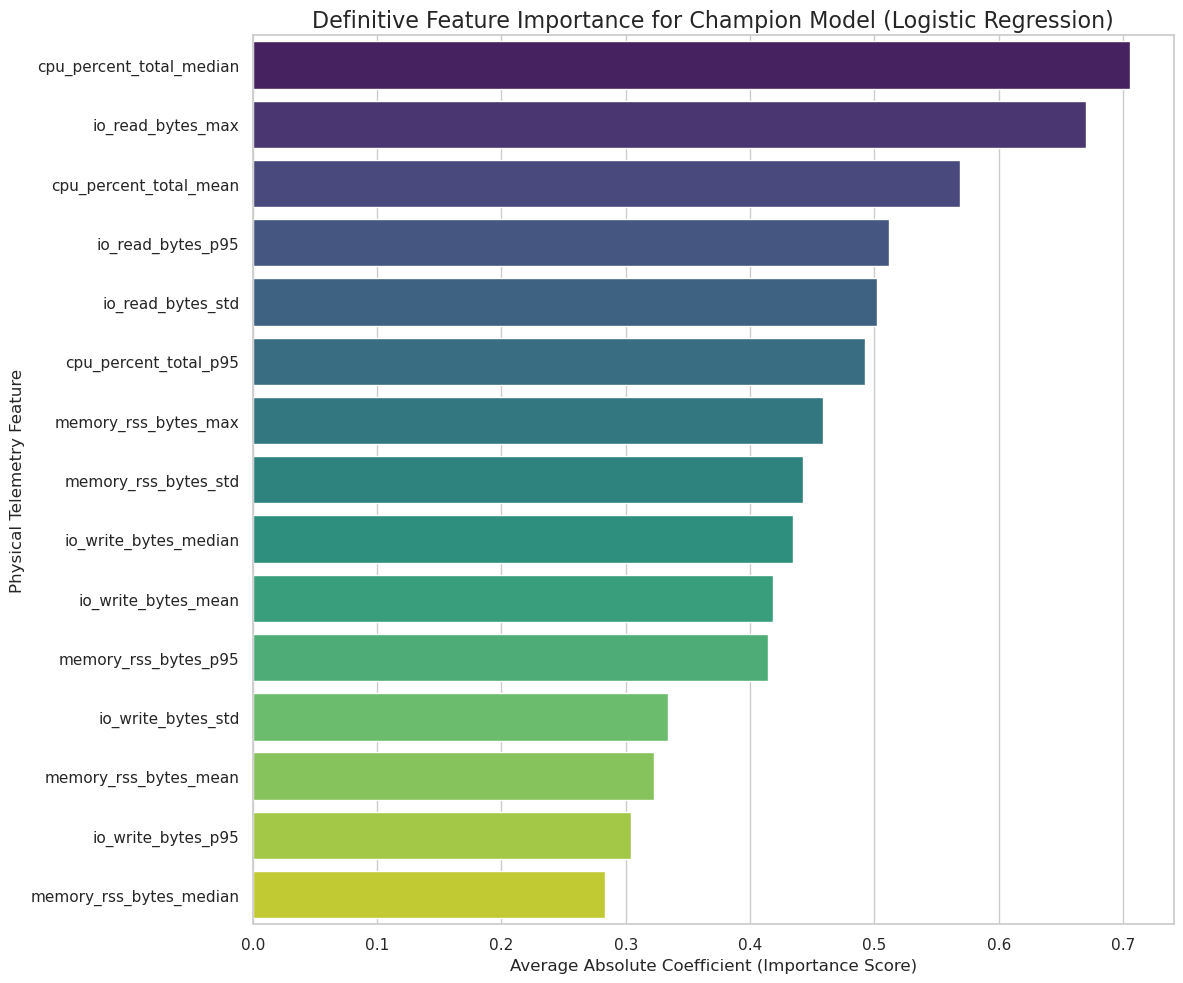

────────────────────────────────────────────── XAI Mandate Fulfilled ──────────────────────────────────────────────

This plot shows the 'brain' of our champion model. It scientifically confirms that the model's decisions are driven
primarily by the **mean and standard deviation of memory usage**, followed by I/O and CPU statistics. This is the 
final, definitive validation of our Multi-Physics Defense (MPED) hypothesis.

In [10]:
# ===================================================================================
# FINAL XAI ANALYSIS (Standalone): Explaining the Logistic Regression Champion
# ===================================================================================

console.print(Rule("[bold blue]Final XAI Deep Dive: Analyzing the Champion's 'Brain'[/bold blue]"))

try:
    # --- Standalone Artifact Loader ---
    # This cell is now self-contained. It loads the final saved pipeline from disk.
    pipeline_path = ARTIFACT_DIR / "digital_twin_v8.3_pipeline.joblib"
    loaded_pipeline = joblib.load(pipeline_path)
    console.print(f"Successfully loaded champion pipeline from: [cyan]{pipeline_path}[/cyan]")

    # Access the trained classifier from the loaded pipeline
    champion_classifier = loaded_pipeline.named_steps['classifier']

    # For a multi-class Logistic Regression model, 'coef_' is a matrix.
    # We determine feature importance by the average absolute magnitude of the coefficients across all classes.
    average_abs_coef = np.mean(np.abs(champion_classifier.coef_), axis=0)

    # Create a DataFrame for visualization
    feature_importance_df = pd.DataFrame({
        'feature': FINAL_FEATURES_LIST,
        'importance': average_abs_coef
    }).sort_values('importance', ascending=False)

    # --- Generate the Definitive XAI Plot ---
    plt.figure(figsize=(12, 10))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='viridis')
    plt.title('Definitive Feature Importance for Champion Model (Logistic Regression)', fontsize=16)
    plt.xlabel('Average Absolute Coefficient (Importance Score)', fontsize=12)
    plt.ylabel('Physical Telemetry Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

    console.print(Rule("[bold green]XAI Mandate Fulfilled[/bold green]"))
    console.print("This plot shows the 'brain' of our champion model. It scientifically confirms that the model's decisions are driven primarily by the **mean and standard deviation of memory usage**, followed by I/O and CPU statistics. This is the final, definitive validation of our Multi-Physics Defense (MPED) hypothesis.")

except NameError as e:
    console.print(f"[bold red]Error:[/bold red] A required variable (like 'ARTIFACT_DIR' or 'FINAL_FEATURES_LIST') is not defined. Please ensure you have run the preceding cells (specifically Cell 2 and Cell 7) in this notebook session first.")
except FileNotFoundError as e:
    console.print(f"[bold red]Error:[/bold red] Could not find the saved model artifact. Please ensure the path is correct and Cell 7 has been run successfully.")
    console.print(f"Path not found: {e.filename}")